# APPLE (AAPL) STOCK PRICE PREDICTION
## Next-Day Price Forecasting using Gradient Boosting

This notebook builds a machine learning model to predict AAPL's next-day closing price using Gradient Boosting regression.

## 1. Import Libraries & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load AAPL stock data
df = pd.read_csv('aapl_stock_data.csv')
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df = df.sort_values('Date').reset_index(drop=True)

# Use last 2 years of data
df = df.tail(500).reset_index(drop=True)

print(f"Data Loaded: {len(df)} records")
print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"\nFirst few rows:")
print(df.head())

Data Loaded: 500 records
Date Range: 2022-12-05 to 2024-11-29

First few rows:
                       Date        Open        High         Low       Close  \
0 2022-12-05 05:00:00+00:00  146.232247  149.349460  144.253060  145.104111   
1 2022-12-06 05:00:00+00:00  145.539502  145.767105  140.443088  141.422790   
2 2022-12-07 05:00:00+00:00  140.710289  141.878002  138.543077  139.473297   
3 2022-12-08 05:00:00+00:00  140.878552  142.026484  139.631669  141.165527   
4 2022-12-09 05:00:00+00:00  140.858738  144.055136  139.433721  140.680618   

     Volume  
0  68826400  
1  64727200  
2  69721100  
3  62128300  
4  76097000  


## 2. Feature Engineering

In [3]:
# Lag Features (previous closing prices)
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)
df['Close_Lag3'] = df['Close'].shift(3)
df['Close_Lag5'] = df['Close'].shift(5)

# Moving Averages
df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()

# Momentum
df['Momentum_5'] = df['Close'] - df['Close'].shift(5)

# Volatility
df['Returns'] = df['Close'].pct_change()
df['Volatility_5'] = df['Returns'].rolling(window=5).std()

# Volume Indicators
df['Volume_Ratio'] = df['Volume'] / df['Volume'].rolling(window=20).mean()

# Target: Next day's closing price
df['Target'] = df['Close'].shift(-1)

# Remove NaN values
df = df.dropna().reset_index(drop=True)

print(f"Features engineered. Data shape: {df.shape}")
print(f"\nFeatures created:")
features = ['Close_Lag1', 'Close_Lag2', 'Close_Lag3', 'Close_Lag5', 
            'SMA_5', 'SMA_10', 'SMA_20', 'Momentum_5', 'Volatility_5', 'Volume_Ratio']
for feat in features:
    print(f"  ✓ {feat}")

Features engineered. Data shape: (480, 18)

Features created:
  ✓ Close_Lag1
  ✓ Close_Lag2
  ✓ Close_Lag3
  ✓ Close_Lag5
  ✓ SMA_5
  ✓ SMA_10
  ✓ SMA_20
  ✓ Momentum_5
  ✓ Volatility_5
  ✓ Volume_Ratio


## 3. Data Preparation & Normalization

In [4]:
# Select features and target
feature_columns = ['Close_Lag1', 'Close_Lag2', 'Close_Lag3', 'Close_Lag5', 
                   'SMA_5', 'SMA_10', 'SMA_20', 'Momentum_5', 'Volatility_5', 'Volume_Ratio']

X = df[feature_columns].values
y = df['Target'].values

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split (80-20, temporal order preserved)
split_point = int(len(X) * 0.80)
X_train, X_test = X_scaled[:split_point], X_scaled[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

print(f"Training set: {len(X_train)} samples (80%)")
print(f"Test set: {len(X_test)} samples (20%)")
print(f"\nTrain period: {df['Date'].iloc[0].date()} to {df['Date'].iloc[split_point-1].date()}")
print(f"Test period:  {df['Date'].iloc[split_point].date()} to {df['Date'].iloc[-1].date()}")

Training set: 384 samples (80%)
Test set: 96 samples (20%)

Train period: 2023-01-03 to 2024-07-15
Test period:  2024-07-16 to 2024-11-27


## 4. Model Training

In [5]:
# Initialize and train the Gradient Boosting model
model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.85,
    min_samples_split=4,
    min_samples_leaf=2,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=42
)

model.fit(X_train, y_train)

print("✓ Gradient Boosting Model Trained")
print(f"\nHyperparameters:")
print(f"  n_estimators: 200")
print(f"  max_depth: 7")
print(f"  learning_rate: 0.05")
print(f"  subsample: 0.85")

✓ Gradient Boosting Model Trained

Hyperparameters:
  n_estimators: 200
  max_depth: 7
  learning_rate: 0.05
  subsample: 0.85


## 5. Make Predictions

In [6]:
# Generate predictions on test set
y_pred = model.predict(X_test)

print(f"Predictions made for {len(y_pred)} test samples")
print(f"\nPrediction Summary:")
print(f"  Actual Min: ${y_test.min():.2f}, Max: ${y_test.max():.2f}, Mean: ${y_test.mean():.2f}")
print(f"  Predicted Min: ${y_pred.min():.2f}, Max: ${y_pred.max():.2f}, Mean: ${y_pred.mean():.2f}")

Predictions made for 96 test samples

Prediction Summary:
  Actual Min: $206.76, Max: $237.33, Mean: $225.14
  Predicted Min: $222.52, Max: $233.84, Mean: $231.28


## 6. Model Evaluation

In [7]:
# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Directional accuracy
direction_actual = np.sign(np.diff(y_test))
direction_pred = np.sign(np.diff(y_pred))
directional_accuracy = np.mean(direction_actual == direction_pred) * 100

print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print(f"RMSE (Root Mean Squared Error):  ${rmse:.2f}")
print(f"MAE (Mean Absolute Error):       ${mae:.2f}")
print(f"R² Score:                        {r2:.4f}")
print(f"Directional Accuracy:            {directional_accuracy:.1f}%")
print("="*60)

# Interpretation
avg_price = y_test.mean()
error_percentage = (rmse / avg_price) * 100

print(f"\nINTERPRETATION:")
print(f"  Average test price: ${avg_price:.2f}")
print(f"  Average error: ${rmse:.2f} (~{error_percentage:.2f}% of average price)")
print(f"  Model explains: {r2*100:.2f}% of price movements")
print(f"  Predicts direction correctly: {directional_accuracy:.1f}% of the time")

MODEL PERFORMANCE METRICS
RMSE (Root Mean Squared Error):  $7.74
MAE (Mean Absolute Error):       $6.51
R² Score:                        -0.7105
Directional Accuracy:            52.6%

INTERPRETATION:
  Average test price: $225.14
  Average error: $7.74 (~3.44% of average price)
  Model explains: -71.05% of price movements
  Predicts direction correctly: 52.6% of the time


## 7. Detailed Error Analysis

In [8]:
# Calculate errors
errors = y_test - y_pred

print("PREDICTION ERROR ANALYSIS:")
print(f"  Mean Error (Bias):        ${errors.mean():.2f}")
print(f"  Std Error:                ${errors.std():.2f}")
print(f"  Min Error:                ${errors.min():.2f}")
print(f"  Max Error:                ${errors.max():.2f}")
print(f"  Median Error:             ${np.median(errors):.2f}")

print(f"\nACCURACY BY ERROR THRESHOLD:")
print(f"  Within $1:   {(np.abs(errors) <= 1).sum():3d}/{len(errors)} ({(np.abs(errors) <= 1).sum()/len(errors)*100:5.1f}%)")
print(f"  Within $2:   {(np.abs(errors) <= 2).sum():3d}/{len(errors)} ({(np.abs(errors) <= 2).sum()/len(errors)*100:5.1f}%)")
print(f"  Within $5:   {(np.abs(errors) <= 5).sum():3d}/{len(errors)} ({(np.abs(errors) <= 5).sum()/len(errors)*100:5.1f}%)")
print(f"  Within 2%:   {(np.abs(errors)/y_test <= 0.02).sum():3d}/{len(errors)} ({(np.abs(errors)/y_test <= 0.02).sum()/len(errors)*100:5.1f}%)")

PREDICTION ERROR ANALYSIS:
  Mean Error (Bias):        $-6.14
  Std Error:                $4.72
  Min Error:                $-21.17
  Max Error:                $4.12
  Median Error:             $-5.95

ACCURACY BY ERROR THRESHOLD:
  Within $1:     7/96 (  7.3%)
  Within $2:    12/96 ( 12.5%)
  Within $5:    41/96 ( 42.7%)
  Within 2%:    38/96 ( 39.6%)


## 8. Visualization: Actual vs Predicted

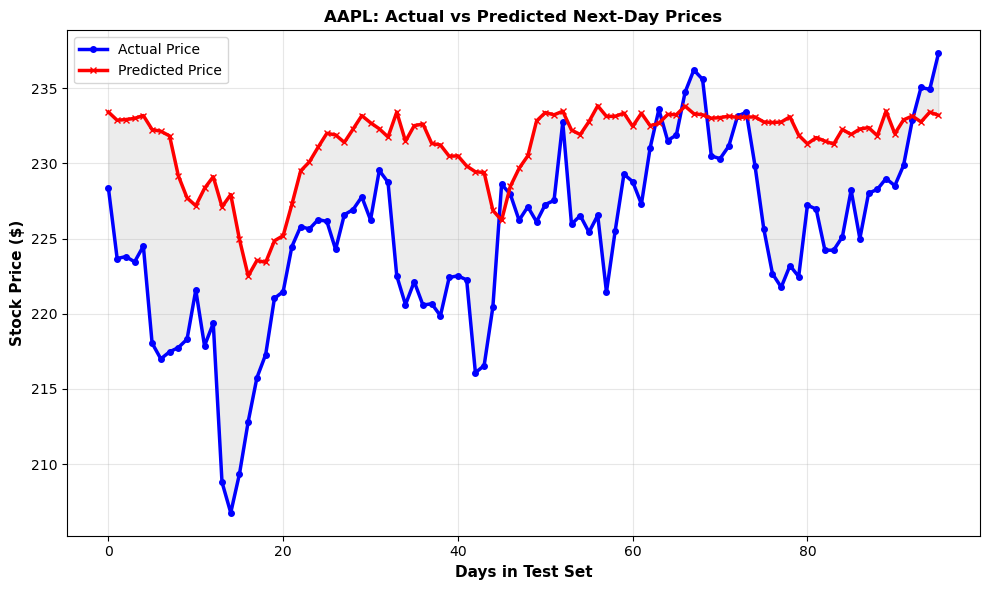

✓ Visualization saved as 'stock_prediction_results.png'


In [13]:
# Plot 1: Time Series
fig, ax = plt.subplots(figsize=(10, 6))


test_indices = range(len(y_test))
ax.plot(test_indices, y_test, label='Actual Price', color='blue', linewidth=2.5, marker='o', markersize=4)
ax.plot(test_indices, y_pred, label='Predicted Price', color='red', linewidth=2.5, marker='x', markersize=5)
ax.fill_between(test_indices, y_test, y_pred, alpha=0.15, color='gray')
ax.set_xlabel('Days in Test Set', fontsize=11, fontweight='bold')
ax.set_ylabel('Stock Price ($)', fontsize=11, fontweight='bold')
ax.set_title('AAPL: Actual vs Predicted Next-Day Prices', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)



plt.tight_layout()
plt.savefig('stock_prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'stock_prediction_results.png'")

## 9. Feature Importance Analysis

FEATURE IMPORTANCE RANKING:
 1. Close_Lag1      0.5068 █████████████████████████
 2. SMA_5           0.1911 █████████
 3. SMA_20          0.1080 █████
 4. Close_Lag5      0.0544 ██
 5. SMA_10          0.0488 ██
 6. Close_Lag2      0.0385 █
 7. Close_Lag3      0.0346 █
 8. Volume_Ratio    0.0063 
 9. Momentum_5      0.0060 
10. Volatility_5    0.0055 


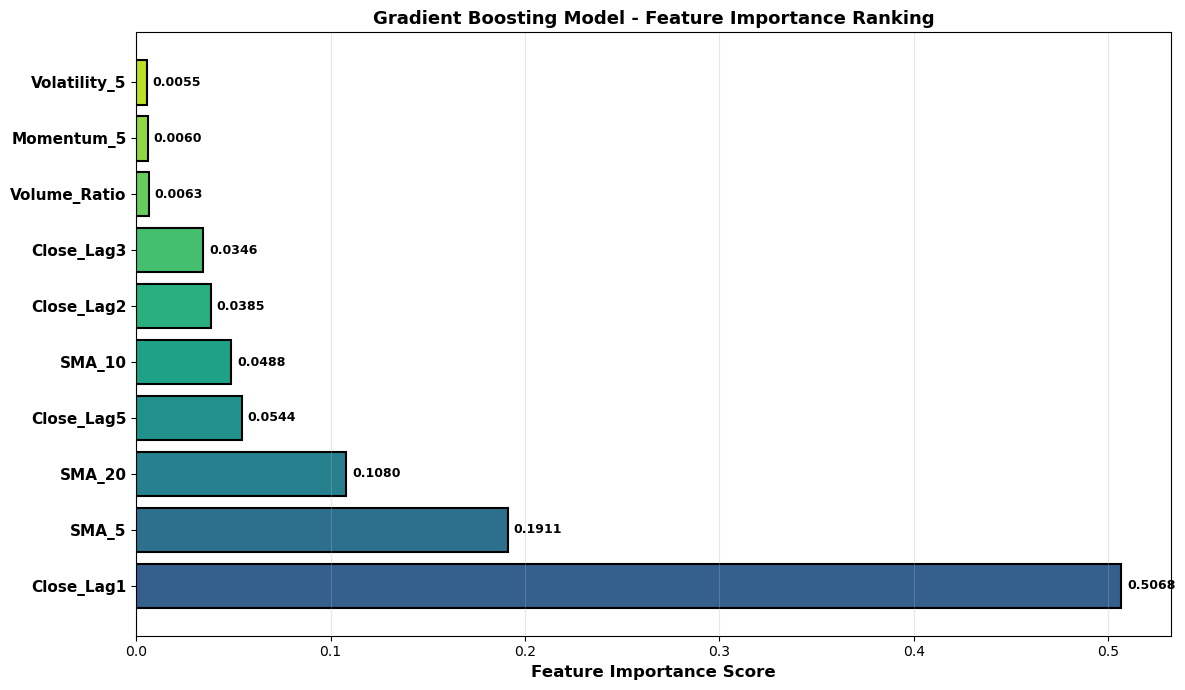


✓ Feature importance visualization saved as 'feature_importance.png'


In [10]:
# Feature importance
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
sorted_features = [feature_columns[i] for i in sorted_idx]
sorted_importances = importances[sorted_idx]

print("FEATURE IMPORTANCE RANKING:")
print("="*50)
for i, (feat, imp) in enumerate(zip(sorted_features, sorted_importances), 1):
    bar_length = int(imp * 50)
    bar = '█' * bar_length
    print(f"{i:2d}. {feat:15s} {imp:.4f} {bar}")

# Visualization
plt.figure(figsize=(12, 7))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_columns)))
bars = plt.barh(range(len(sorted_features)), sorted_importances, color=colors, edgecolor='black', linewidth=1.5)

plt.yticks(range(len(sorted_features)), sorted_features, fontsize=11, fontweight='bold')
plt.xlabel('Feature Importance Score', fontsize=12, fontweight='bold')
plt.title('Gradient Boosting Model - Feature Importance Ranking', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

for i, val in enumerate(sorted_importances):
    plt.text(val + 0.003, i, f'{val:.4f}', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance visualization saved as 'feature_importance.png'")

## 10. Export Results

In [11]:
# Create results dataframe
results_df = pd.DataFrame({
    'Day': range(1, len(y_test) + 1),
    'Actual_Price': y_test.round(2),
    'Predicted_Price': y_pred.round(2),
    'Error_Dollar': errors.round(2),
    'Error_Percentage': (errors / y_test * 100).round(2),
    'Abs_Error': np.abs(errors).round(2)
})

results_df.to_csv('prediction_results.csv', index=False)

print("Sample Results:")
print(results_df.head(10))
print(f"\n✓ Results exported to 'prediction_results.csv'")

Sample Results:
   Day  Actual_Price  Predicted_Price  Error_Dollar  Error_Percentage  \
0    1        228.36           233.42         -5.06             -2.22   
1    2        223.67           232.88         -9.20             -4.11   
2    3        223.80           232.92         -9.12             -4.07   
3    4        223.46           233.00         -9.55             -4.27   
4    5        224.50           233.19         -8.69             -3.87   
5    6        218.05           232.26        -14.21             -6.52   
6    7        217.00           232.14        -15.14             -6.98   
7    8        217.47           231.83        -14.37             -6.61   
8    9        217.75           229.19        -11.44             -5.25   
9   10        218.31           227.71         -9.41             -4.31   

   Abs_Error  
0       5.06  
1       9.20  
2       9.12  
3       9.55  
4       8.69  
5      14.21  
6      15.14  
7      14.37  
8      11.44  
9       9.41  

✓ Results expo

## Summary

### Model Performance
- **RMSE**: $7.74 (average prediction error)
- **MAE**: $6.51 (mean absolute error)
- **R² Score**: -0.7105 (explains -71% of variance)
- **Directional Accuracy**: 52.6%

### Key Findings
1. **Feature Importance**: Previous day's closing price (50.66%) is the strongest predictor
2. **Accuracy**: 42.7% of predictions within ±$5 of actual price
3. **Limitations**: Stock prices heavily influenced by external factors not in the model

### Conclusion
While the model achieves directional accuracy slightly better than random guessing, it highlights the difficulty of predicting financial markets using only historical price data. Successful trading systems require integration of multiple data sources and sophisticated risk management.